In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from astropy.constants import R_earth
from astropy.coordinates import solar_system_ephemeris
from glob import glob
from fptemp_study import RunFPTempModels
from collections import defaultdict
from sparkles.roll_optimize import allowed_rolldev

/Users/jzuhone/miniconda3/envs/ska/lib/python3.8/site-packages/proseco/characteristics.py:97: UserWarning: Unable to find /Users/jzuhone/ska/data/agasc/agasc_supplement.h5, using limited bad star set
  warnings.warn(f'Unable to find {agasc_supplement_file}, using limited bad star set')


In [2]:
runner = RunFPTempModels("2021:001:00:00:00", "2023:365:23:59:59")

In [3]:
tini = "m109"

In [4]:
solar_system_ephemeris.set('jpl')
R_e = R_earth.to_value("km")

In [5]:
fns = glob(f"data/acisfp_model_perigee_2019_*{tini}.h5")
fns += glob(f"data/acisfp_model_perigee_2020_*{tini}.h5")
fns.sort()

In [6]:
print(len(fns))

819


In [7]:
years = [fn.split("_")[4] for fn in fns]
unique_years = list(set(years))
unique_years.sort()
num_uy = len(unique_years)

In [8]:
plt.rc("font", size=17)
plt.rc("axes", linewidth=2)
current_year = ""
fig, axes = plt.subplots(nrows=3, ncols=num_uy, figsize=(20,20))
tmin = defaultdict(lambda: 1.0e99) 
tmax = defaultdict(lambda: -1.0e99) 
bad_pitches = 0
bad_rolls = 0
maxtemps = {}
endtemps = {}
for i, fn in enumerate(fns):
    year = years[i]
    j = unique_years.index(year)
    if year != current_year:
        current_year = year
        maxtemps[current_year] = []
        endtemps[current_year] = []
    with h5py.File(fn, "r") as f:
        pitch = f["pitch"][()]
        roll = f['roll'][()]
        if pitch.min() < 46.2:
            #print("oops!", pitch.min())
            bad_pitches += 1
            continue
        droll = allowed_rolldev(pitch).data
        if np.logical_or(roll < -droll, roll > roll).any():
            #print("bad roll", roll.min(), roll.max())
            bad_rolls += 1
            continue
        times = f['times'][()]*1.0e-3
        r = np.sqrt(
            f["ephem_x"][()]**2+
            f["ephem_y"][()]**2+
            f["ephem_z"][()]**2
        )*1.0e-3
        tperigee = times[np.argmin(r)]
        #tperigee = runner.per_times[i]*1.0e-3
        times -= tperigee
        t = f['ephem_t'][()]*1.0e-3-tperigee
        tmin[j] = min(times[0], tmin[j])
        tmax[j] = max(times[-1], tmax[j])
        a = r - R_e
        temp = f['fptemp'][()]
        esa = f['esa'][()]
        maxtemps[current_year].append(temp.max())
        endtemps[current_year].append(temp[-1])
        axes[0, j].plot(times, temp, '-', lw=2)
        axes[1, j].plot(t, a, '-', lw=2)
        axes[2, j].plot(times, esa, '-', lw=2)
for i, ax in enumerate(axes[0]):
    ax.set_title(unique_years[i], fontsize=18)
    ax.set_xticks([-30, -20, -10, 0, 10, 20, 30])
    ax.set_xticklabels([])
    if i == 0:
        ax.set_ylabel("FPTEMP ($^\circ$C)")
    else:
        ax.set_yticklabels([])
    ax.set_ylim(-120, -75)
    ax.axvline(0.0, lw=2, color='k', ls='--')
    ax.tick_params(which='major', width=2, length=6)
for i, ax in enumerate(axes[1]):
    ax.set_xticks([-30, -20, -10, 0, 10, 20, 30])
    ax.set_xticklabels([])
    ax.set_yscale("log")
    ax.set_ylim(800, 1.0e5)
    if i == 0:
        ax.set_ylabel("Altitude (km)")
    else:
        ax.set_yticklabels([])
    ax.axvline(0.0, lw=2, color='k', ls='--')
    ax.tick_params(which='major', width=2, length=6)
    ax.tick_params(which='minor', width=2, length=3)
for i, ax in enumerate(axes[2]):
    ax.set_xticks([-30, -20, -10, 0, 10, 20, 30])
    ax.set_yscale("log")
    ax.set_ylim(1.0e-4, 6)
    if i == 0:
        ax.set_ylabel("Earth Solid Angle (sr)")
    else:
        ax.set_yticklabels([])
    ax.axvline(0.0, lw=2, color='k', ls='--')
    ax.set_xlabel("t (ks)")
    ax.tick_params(which='major', width=2, length=6)
    ax.tick_params(which='minor', width=2, length=3)
for i in range(3):
    for j in range(3):
        axes[i, j].set_xlim(tmin[j], tmax[j])
fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.savefig(f"2020to2024_perigees_recent_{tini}.pdf")

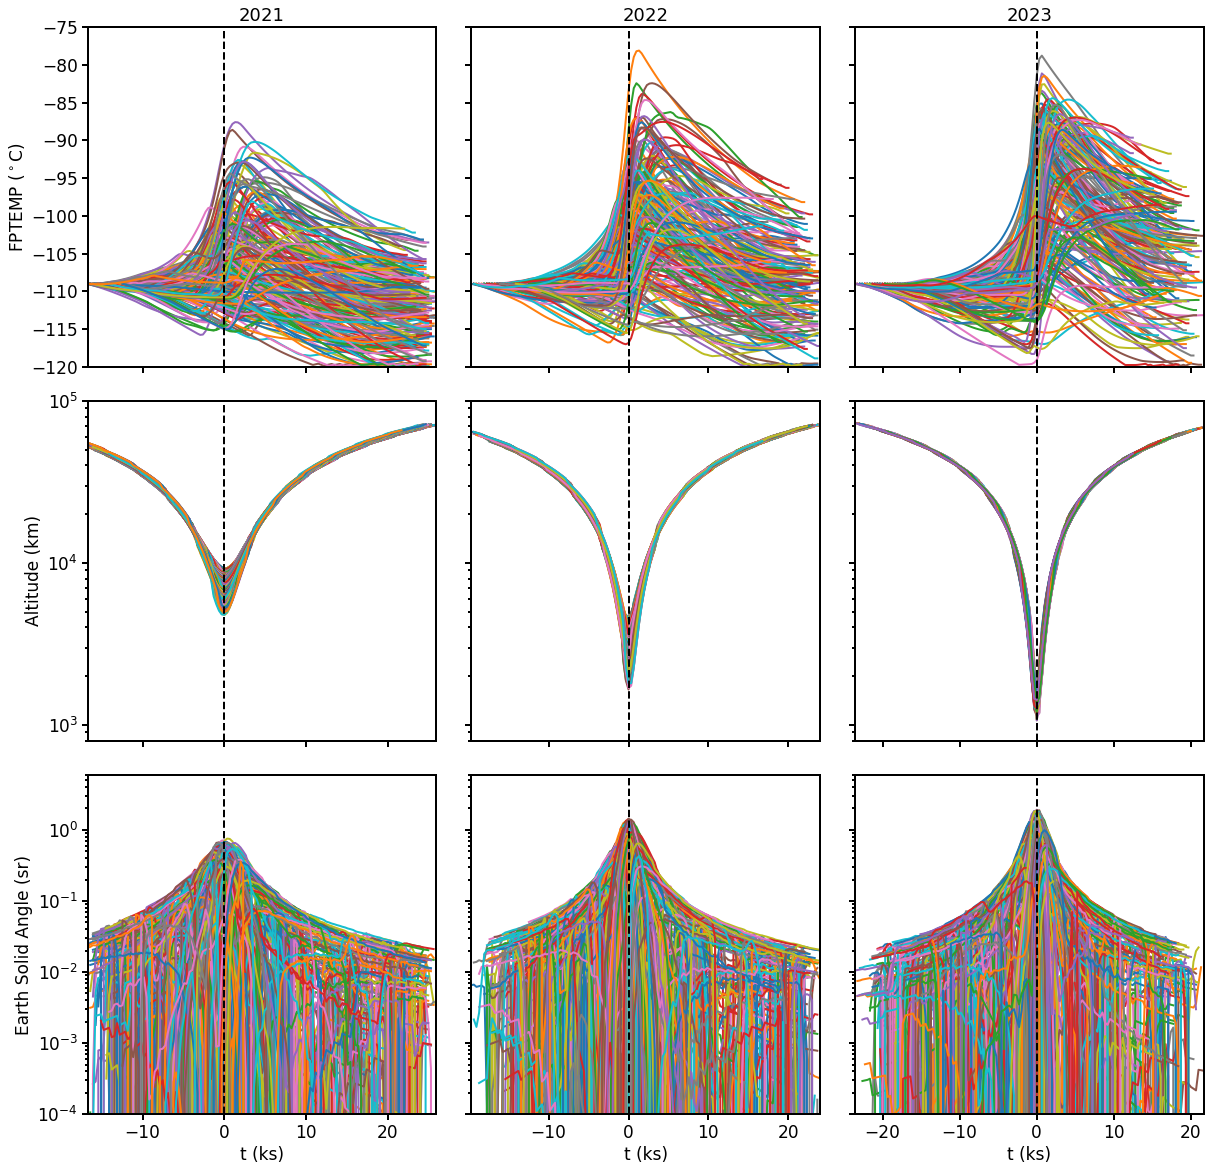

In [9]:
fig

In [10]:
temp_bins = np.linspace(-120.0, -70.0, 21)

In [11]:
plt.rc("font", size=17)
plt.rc("axes", linewidth=2)
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(32,10))
_, _, _= ax1.hist(endtemps['2021'], bins=temp_bins)
ax1.tick_params(length=6, width=2)
ax1.set_title("2021")
ax1.set_xlabel("End FPTEMP_11 ($^\circ$C)")
ax1.set_ylabel("N")
ax1.set_ylim(0, 30)
_, _, _ = ax2.hist(endtemps['2022'], bins=temp_bins)
ax2.tick_params(length=6, width=2)
ax2.set_title("2022")
ax2.set_xlabel("End FPTEMP_11 ($^\circ$C)")
ax2.set_ylim(0, 30)
_, _, _ = ax3.hist(endtemps['2023'], bins=temp_bins)
ax3.tick_params(length=6, width=2)
ax3.set_title("2023")
ax3.set_xlabel("End FPTEMP_11 ($^\circ$C)")
ax3.set_ylim(0, 30)
for ax in [ax1, ax2, ax3]:
    ax.set_xlim(-120.0, -85)
    ax.axvline(-112,  ls='--', lw=3, color='k')
    ax.axvline(-111,  ls='--', lw=3, color='k')
    ax.axvline(-109, ls='--', lw=3, color='k')
fig.savefig(f"2020to2024_perigees_recent_{tini}_hist_end.pdf")

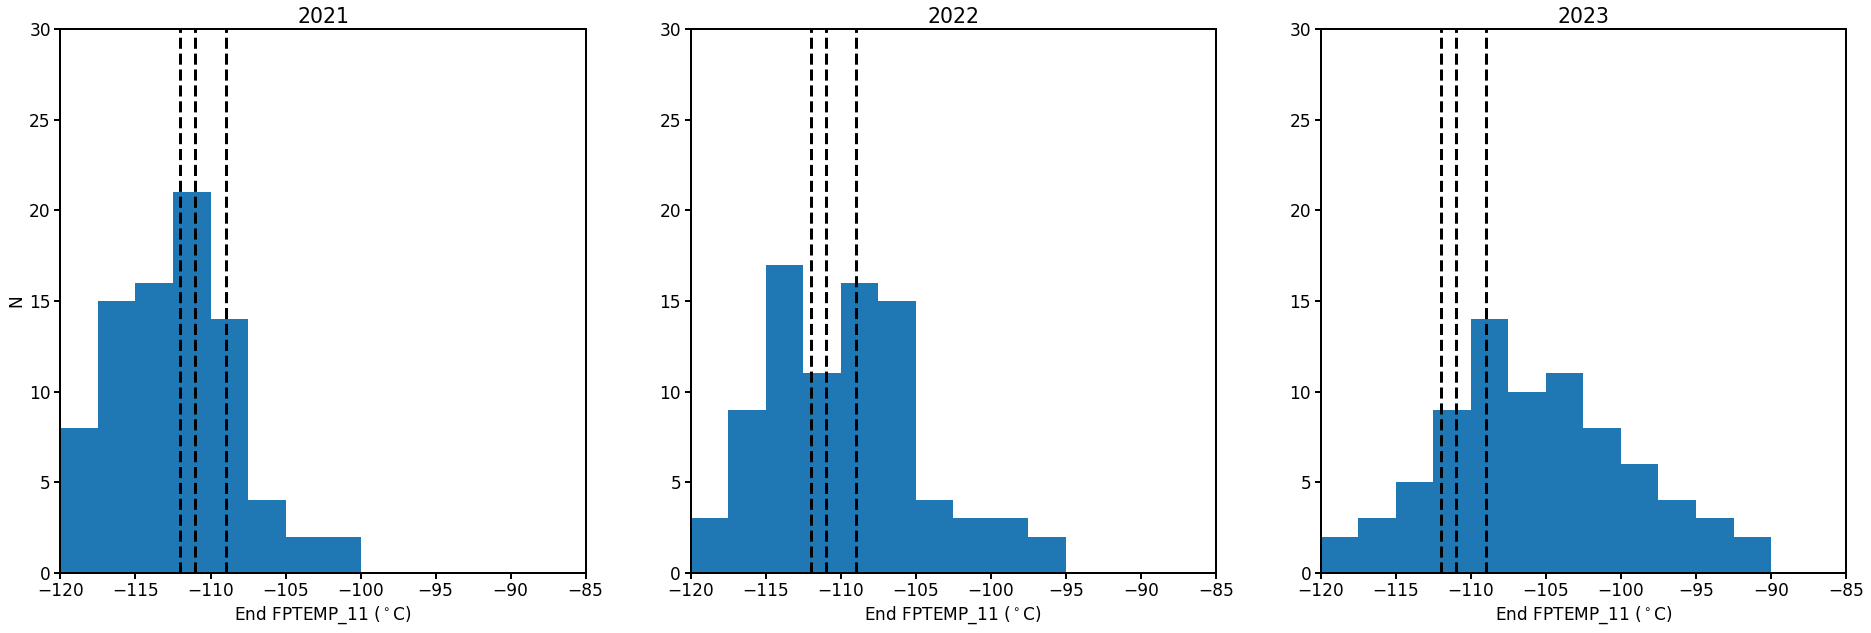

In [12]:
fig

In [13]:
plt.rc("font", size=17)
plt.rc("axes", linewidth=2)
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(32,10))
_, _, _= ax1.hist(maxtemps['2021'], bins=temp_bins)
ax1.tick_params(length=6, width=2)
ax1.set_title("2021")
ax1.set_xlabel("Maximum FPTEMP_11 ($^\circ$C)")
ax1.set_ylim(0, 30)
ax1.set_ylabel("N")
_, _, _ = ax2.hist(maxtemps['2022'], bins=temp_bins)
ax2.tick_params(length=6, width=2)
ax2.set_title("2022")
ax2.set_xlabel("Maximum FPTEMP_11 ($^\circ$C)")
ax2.set_ylim(0, 30)
_, _, _ = ax3.hist(maxtemps['2023'], bins=temp_bins)
ax3.tick_params(length=6, width=2)
ax3.set_title("2023")
ax3.set_xlabel("Maximum FPTEMP_11 ($^\circ$C)")
ax3.set_ylim(0, 30)
for ax in [ax1, ax2, ax3]:
    ax.set_xlim(-120.0, -78)
    ax.axvline(-80, ls='--', lw=3, color='k')
fig.savefig(f"2020to2024_perigees_recent_{tini}_hist_max.pdf")

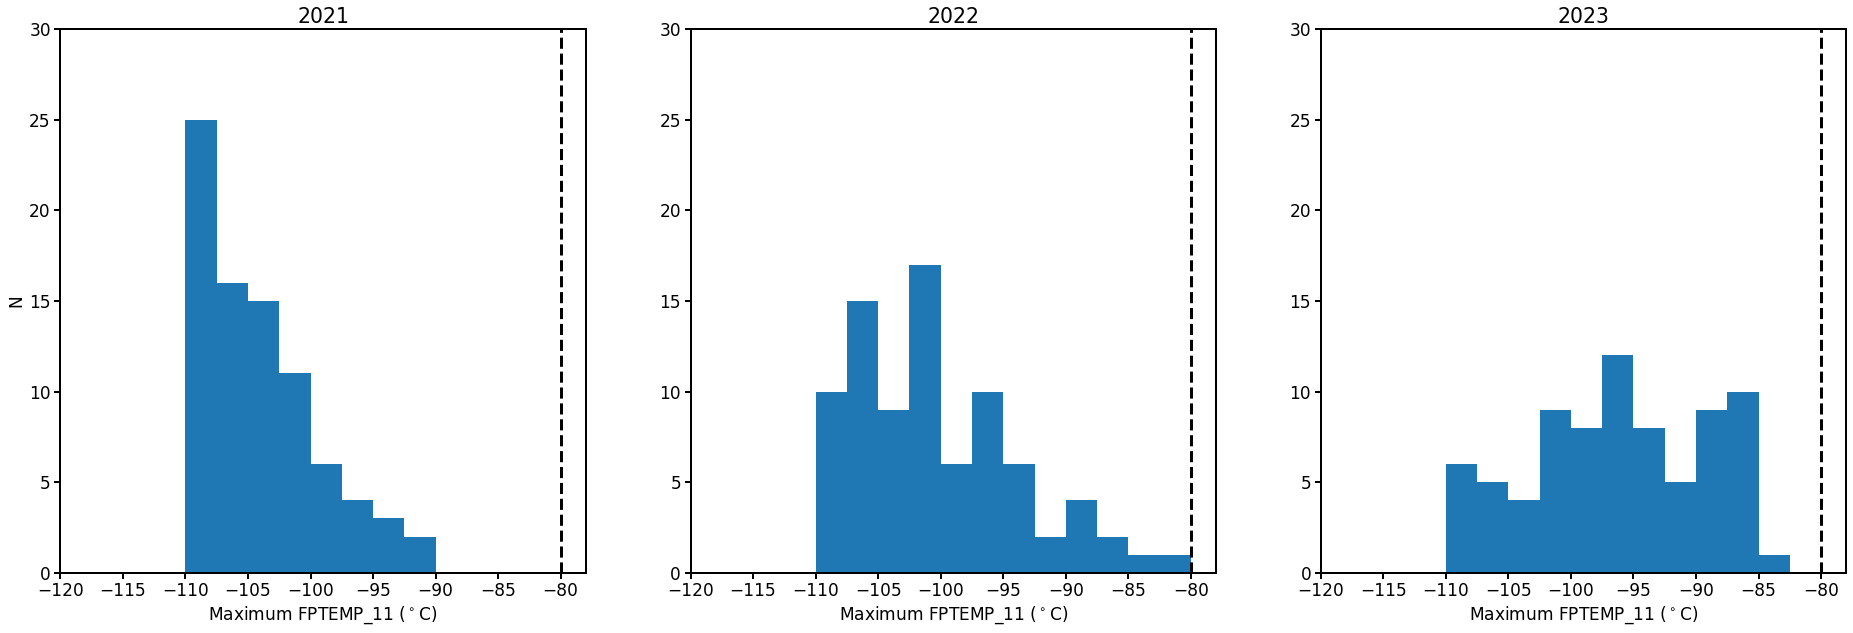

In [14]:
fig